# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

Training LinearRegression...


/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['country' 'borough' 'bathrooms' 'minstay']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['country' 'borough' 'bathrooms' 'minstay']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635:

Training Lasso...


/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['country' 'borough' 'bathrooms' 'minstay']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['country' 'borough' 'bathrooms' 'minstay']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['country' 'borough' 'bathrooms' 'minstay']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/s

Training DecisionTreeRegressor...


/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/home/eurico-martins/Repos/AIFundamentsClass/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve t

Best Model: LinearRegression
Best Parameters: {'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__num__imputer__fill_value': 0}
Best Preprocessing Details: {'numeric_features': ['room_id', 'survey_id', 'host_id', 'country', 'borough', 'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'bathrooms', 'minstay', 'latitude', 'longitude'], 'categorical_features': ['room_type', 'city', 'neighborhood', 'name', 'last_modified', 'location'], 'correlation_method': 'kendall', 'dimensionality_reduction': 'PCA'}

Metrics for LinearRegression:
Training: {'rmse': np.float64(113.37263395562087), 'mse': 12853.354130035199, 'mae': 37.827967589172005, 'mape': 0.4922590359928758, 'r2': 0.1222463777568068}
Testing: {'rmse': np.float64(123.67473701833396), 'mse': 15295.440576554063, 'mae': 38.726590804448406, 'mape': 0.5087192122755839, 'r2': 0.10657320399190051}
Preprocessing: {'numeric_features': ['room_id', 'survey_id', 'host_id', 'country', 'borough', 'reviews', 'overall_satis

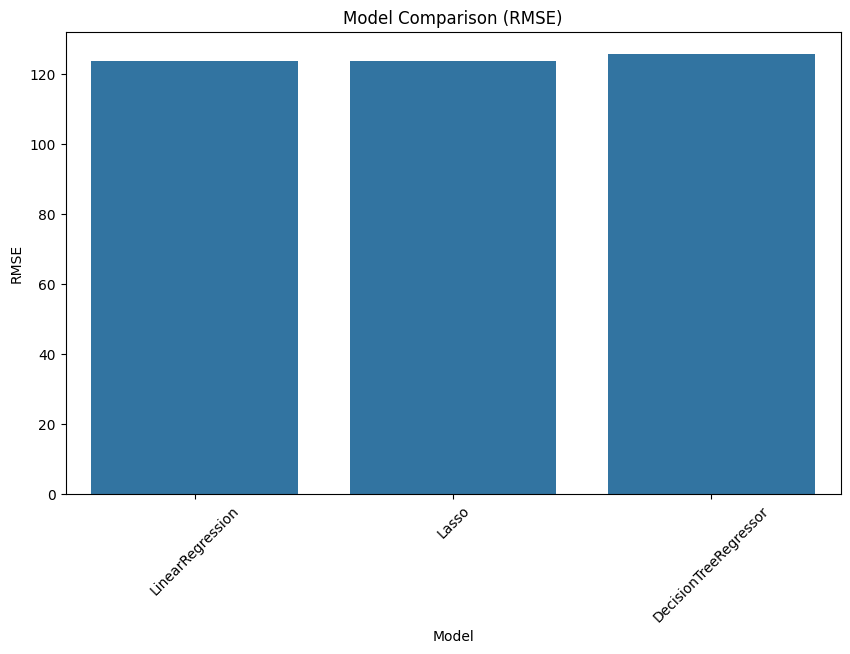

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import seaborn as sns
import time

class AutoMLPipeline:
    def __init__(self, models=None, param_grids=None, metric='rmse'):
        # Default models and parameter grids
        self.models = models or {
            'LinearRegression': LinearRegression(),
            'Lasso': Lasso(),
            'DecisionTreeRegressor': DecisionTreeRegressor()
        }
        self.param_grids = param_grids or {
            'LinearRegression': {
                'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant'],
                'preprocessor__num__imputer__fill_value': [0],  # Applies if strategy is 'constant'
            },
            'Lasso': {
                'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant'],
                'preprocessor__num__imputer__fill_value': [0],
                'model__alpha': [0.01, 0.1, 1, 10]
            },
            'DecisionTreeRegressor': {
                'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant'],
                'preprocessor__num__imputer__fill_value': [0],
                'model__max_depth': [3, 5, 10, None],
                'model__min_samples_split': [2, 5, 10]
            }
        }
        self.metric = metric
        self.best_model = None
        self.best_params = None
        self.model_scores = {}
        self.best_preprocessing_details = None
        self.metrics = {
            'rmse': lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
            'mse': mean_squared_error,
            'mae': mean_absolute_error,
            'mape': mean_absolute_percentage_error,
            'r2': r2_score
        }

    def preprocess_data(self, X, y):
        # Identify numeric and categorical columns
        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = X.select_dtypes(include=['object', 'category']).columns

        # Create preprocessing pipelines for numeric and categorical data
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine preprocessing steps
        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        return preprocessor, numeric_features, categorical_features

    def select_correlation_method(self, X, y):
        _, p_value = normaltest(y)
        if p_value < 0.05:
            # Non-normal distribution
            if len(X) < 500:
                return 'spearman'
            else:
                return 'kendall'
        else:
            return 'pearson'

    def reduce_dimensionality(self, X):
        if X.shape[1] > 10:  # Example threshold
            return PCA(n_components=3)
        return 'passthrough'

    def create_pipeline(self, model, X, y):
        correlation_method = self.select_correlation_method(X, y)
        preprocessor, numeric_features, categorical_features = self.preprocess_data(X, y)
        dimensionality_reduction = self.reduce_dimensionality(X)

        # Store preprocessing details
        preprocessing_details = {
            'numeric_features': numeric_features.tolist(),
            'categorical_features': categorical_features.tolist(),
            'correlation_method': correlation_method,
            'dimensionality_reduction': 'PCA' if isinstance(dimensionality_reduction, PCA) else 'None'
        }

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('dim_reduction', dimensionality_reduction),
            ('model', model)
        ])

        return pipeline, preprocessing_details

    def train(self, X, y, test_size=0.2, random_state=42, max_time=None):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        if self.metric not in self.metrics:
            raise ValueError(f"Unsupported metric: {self.metric}. Choose from {list(self.metrics.keys())}.")

        scorer = make_scorer(mean_squared_error, greater_is_better=False)
        start_time = time.time()

        results = {}

        for model_name, model in self.models.items():
            elapsed_time = time.time() - start_time
            if max_time and elapsed_time > max_time:
                print("Max training time reached. Stopping further training.")
                break

            print(f"Training {model_name}...")
            pipeline, preprocessing_details = self.create_pipeline(model, X_train, y_train)
            param_grid = self.param_grids.get(model_name, {})

            search = RandomizedSearchCV(pipeline, param_distributions=param_grid, scoring=scorer, cv=5, n_iter=10, random_state=random_state)
            search.fit(X_train, y_train)

            best_pipeline = search.best_estimator_
            y_train_pred = best_pipeline.predict(X_train)
            y_test_pred = best_pipeline.predict(X_test)

            metrics_train = {metric_name: func(y_train, y_train_pred) for metric_name, func in self.metrics.items()}
            metrics_test = {metric_name: func(y_test, y_test_pred) for metric_name, func in self.metrics.items()}

            results[model_name] = {
                'train': metrics_train,
                'test': metrics_test,
                'preprocessing': preprocessing_details
            }

            if self.best_model is None or metrics_test[self.metric] < results[self.best_model]['test'][self.metric]:
                self.best_model = model_name
                self.best_params = search.best_params_
                self.best_preprocessing_details = preprocessing_details

        self.model_scores = results

        print(f"Best Model: {self.best_model}")
        print(f"Best Parameters: {self.best_params}")
        print(f"Best Preprocessing Details: {self.best_preprocessing_details}")

        # Display all metrics for each model
        for model_name, metrics in results.items():
            print(f"\nMetrics for {model_name}:")
            print(f"Training: {metrics['train']}")
            print(f"Testing: {metrics['test']}")
            print(f"Preprocessing: {metrics['preprocessing']}")

    def plot_model_comparisons(self):
        if not self.model_scores:
            print("No models have been trained yet.")
            return

        plt.figure(figsize=(10, 6))
        comparison_metric = [metrics['test'][self.metric] for metrics in self.model_scores.values()]
        sns.barplot(x=list(self.model_scores.keys()), y=comparison_metric)
        plt.title(f'Model Comparison ({self.metric.upper()})')
        plt.ylabel(self.metric.upper())
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.show()

# Example Usage
if __name__ == "__main__":
    # Load sample dataset
    from sklearn.datasets import fetch_california_housing

    data = pd.read_csv("../data/learning/airbnb_lisbon/airbnb_lisbon_1480_2017-07-27.csv", header=0, sep=',')
    X = data.drop(['price'], axis=1)
    y = data.price

    # Initialize and run AutoMLPipeline
    automl = AutoMLPipeline(metric='rmse')  # Select the optimization metric
    automl.train(X, y, max_time=60)  # Set max training time to 60 seconds
    automl.plot_model_comparisons()